## Tweet Emotion Recognition: Natural Language Processing with TensorFlow
#### Personal Project
---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Data set is supplied by Coursera 

---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 8.4 MB/s 
     |████████████████████████████████| 243 kB 74.0 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_u = confusion_matrix(y_true, y_pred, normalize=None)

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()
    return cm,cm_u

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

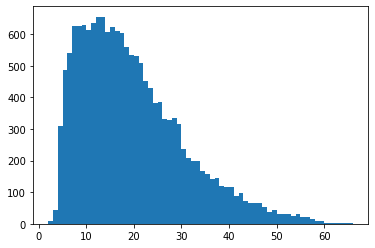

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [ ]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes = set(labels)
print(classes)

{'sadness', 'anger', 'surprise', 'fear', 'joy', 'love'}


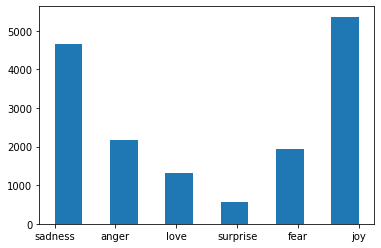

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{'anger': 1, 'fear': 3, 'joy': 4, 'love': 5, 'sadness': 0, 'surprise': 2}

In [ ]:
index_to_classes

{0: 'sadness', 1: 'anger', 2: 'surprise', 3: 'fear', 4: 'joy', 5: 'love'}

In [ ]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [ ]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 18s 17ms/step - loss: 1.3818 - accuracy: 0.3985 - val_loss: 0.9955 - val_accuracy: 0.6370
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.6858 - accuracy: 0.7487 - val_loss: 0.6269 - val_accuracy: 0.7995
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3826 - accuracy: 0.8754 - val_loss: 0.4391 - val_accuracy: 0.8565
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2199 - accuracy: 0.9308 - val_loss: 0.3834 - val_accuracy: 0.8775
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1508 - accuracy: 0.9539 - val_loss: 0.3926 - val_accuracy: 0.8840
Epoch 6/20
500/500 [==============================] - 7s 13ms/step - loss: 0.1084 - accuracy: 0.9660 - val_loss: 0.3802 - val_accuracy: 0.8875
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.0971 - accuracy: 0.9684 - val_loss: 0.3738 - val_accuracy: 0.893

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

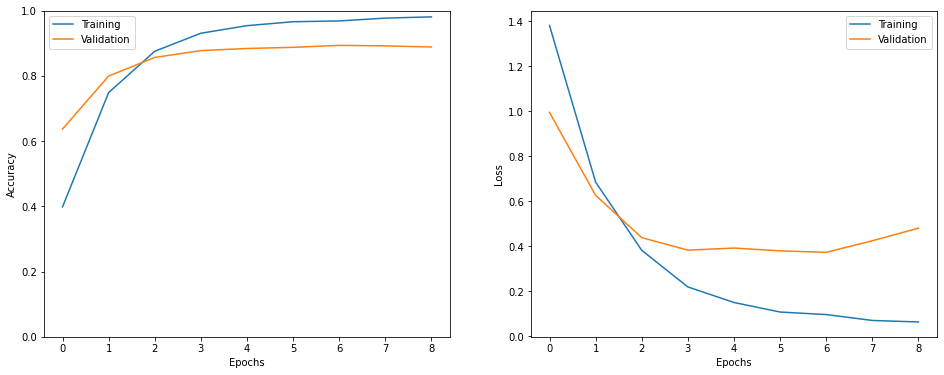

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4562 - accuracy: 0.8835


In [ ]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

print('Predicted Emotion:', index_to_classes.get(p))

Sentence: i embraced feeling thankful that the middle wall of partition had thus far been broken down
Emotion: joy


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted Emotion: joy


In [ ]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


((2000,), (2000,))

### Task 10: Confusion matrix and metrics

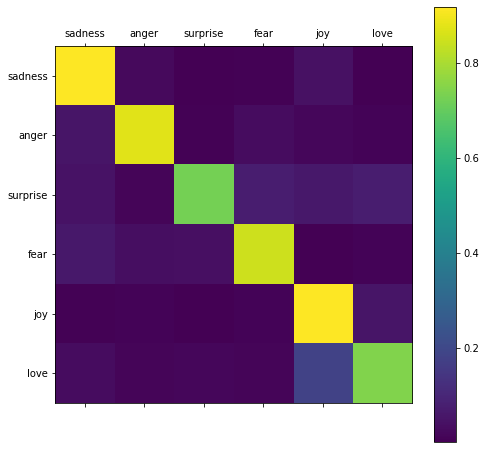

In [ ]:
xx, yy = show_confusion_matrix(test_labels, preds, list(classes))

In [ ]:
yy ## Unnormalised Confusion matrix

array([[533,  15,   1,   5,  25,   2],
       [ 15, 241,   2,   9,   5,   3],
       [  3,   1,  48,   5,   4,   5],
       [ 14,   8,   9, 190,   1,   2],
       [  4,   7,   3,   7, 637,  37],
       [  5,   2,   3,   2,  29, 118]])

In [ ]:
xx #Normalised Confusion matrix

array([[0.91738382, 0.02581756, 0.00172117, 0.00860585, 0.04302926,
        0.00344234],
       [0.05454545, 0.87636364, 0.00727273, 0.03272727, 0.01818182,
        0.01090909],
       [0.04545455, 0.01515152, 0.72727273, 0.07575758, 0.06060606,
        0.07575758],
       [0.0625    , 0.03571429, 0.04017857, 0.84821429, 0.00446429,
        0.00892857],
       [0.0057554 , 0.01007194, 0.00431655, 0.01007194, 0.91654676,
        0.05323741],
       [0.03144654, 0.01257862, 0.01886792, 0.01257862, 0.18238994,
        0.74213836]])

In [ ]:
import sklearn.metrics as m
BA = m.balanced_accuracy_score(test_labels, preds) 
MCC = m.matthews_corrcoef(test_labels, preds)
A = m.accuracy_score(test_labels, preds)
P = m.precision_score(test_labels, preds, average = None)
R = m.recall_score(test_labels, preds, average = None)
F1 = m.f1_score(test_labels, preds, average = None)


print("Balanced Accuracy :", BA)
print("Matthews Correlation Coefficient :", MCC)
print("Accuracy :", A)
print("Precision :", P)
print("F1 Score :", F1)


Report = m.classification_report(test_labels, preds)
print(Report)

Balanced Accuracy : 0.8379865996197885
Matthews Correlation Coefficient : 0.8459366961734918
Accuracy : 0.8835
Precision : [0.92857143 0.87956204 0.72727273 0.87155963 0.90870185 0.70658683]
F1 Score : [0.92294372 0.87795993 0.72727273 0.85972851 0.91260745 0.72392638]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       581
           1       0.88      0.88      0.88       275
           2       0.73      0.73      0.73        66
           3       0.87      0.85      0.86       224
           4       0.91      0.92      0.91       695
           5       0.71      0.74      0.72       159

    accuracy                           0.88      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.88      0.88      0.88      2000

